In [1]:
import train
import numpy as np
import api.capital_features_api as cf
import pandas as pd
import mplfinance as mpf
from datetime import datetime
import joblib
import matplotlib.pyplot as plt
import model_util as mu
from tensorflow import keras
import os
import shutil

model_name = 'v8.40.200.i5.all.ub6.lstm1.sp22y1d.20240212.1'
model_dir = './model/' + model_name + '/'
os.makedirs(model_dir, exist_ok=True)
scaler_save_file = model_dir + 'scaler.save'
scaler_json_file = model_dir + 'scaler.json'
model_h5_file = model_dir + 'model.h5'
model_tf_dir_file = model_dir + 'model_tf'
model_tf_dir_scaler_json_file = model_tf_dir_file + '/scaler.json'

In [2]:
train_ud_data = cf.get_train_data(cf.docker_train_data_url, train_config_id=2059178)
validation_ud_data = cf.get_train_data(cf.docker_train_data_url, train_config_id=2059179)
Y_ud_train = train_ud_data['upSignals']
Y_ud_val = validation_ud_data['upSignals']

In [3]:
train_ud_dataset, validation_ud_dataset, scaler_ud = train.to_dataset(train_ud_data['features'], validation_ud_data['features'], Y_ud_train, Y_ud_val, batch=128)
weights_ud = train.to_weights(Y_ud_train)
joblib.dump(scaler_ud, scaler_save_file)
train.save_scaler(scaler_ud, scaler_json_file)

In [4]:
model_ud, callbacks_ud = train.get_model(40, 5, model_name)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 128)           68608     
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 batch_normalization (BatchN  (None, 40, 128)          512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [5]:
his_ud = model_ud.fit(train_ud_dataset, epochs=500, validation_data=validation_ud_dataset, verbose=1, callbacks=callbacks_ud, class_weight=weights_ud)
model_ud.save(model_h5_file)
model_ud.save(model_tf_dir_file, save_format='tf')
shutil.copy2(scaler_json_file, model_tf_dir_scaler_json_file)

Epoch 1/500
7878/7878 [==============================] - ETA: 0s - loss: 0.7070 - accuracy: 0.5300 - precision: 0.7553 - recall: 0.5555
Epoch 00001: val_loss improved from inf to 0.70706, saving model to ./checkpoint/v8.40.200.i5.all.ub6.lstm1.sp22y1d.20240212.1/epoch_01.ckpt
7878/7878 [==============================] - 190s 23ms/step - loss: 0.7070 - accuracy: 0.5300 - precision: 0.7553 - recall: 0.5555 - val_loss: 0.7071 - val_accuracy: 0.3166 - val_precision: 0.7682 - val_recall: 0.1320 - lr: 0.0010
Epoch 2/500
7878/7878 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5910 - precision: 0.7589 - recall: 0.6692
Epoch 00002: val_loss improved from 0.70706 to 0.68943, saving model to ./checkpoint/v8.40.200.i5.all.ub6.lstm1.sp22y1d.20240212.1/epoch_02.ckpt
7878/7878 [==============================] - 189s 24ms/step - loss: 0.6931 - accuracy: 0.5910 - precision: 0.7589 - recall: 0.6692 - val_loss: 0.6894 - val_accuracy: 0.6960 - val_precision: 0.7567 - val_recall: 

INFO:tensorflow:Assets written to: ./model/v8.40.200.i5.all.ub6.lstm1.sp22y1d.20240212.1/model_tf/assets


INFO:tensorflow:Assets written to: ./model/v8.40.200.i5.all.ub6.lstm1.sp22y1d.20240212.1/model_tf/assets


'./model/v8.40.200.i5.all.ub6.lstm1.sp22y1d.20240212.1/model_tf/scaler.json'

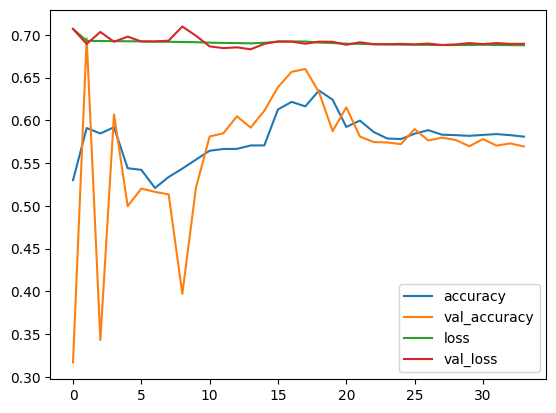

In [9]:
plt.plot(his_ud.history['accuracy'], label='accuracy')
plt.plot(his_ud.history['val_accuracy'], label='val_accuracy')
plt.plot(his_ud.history['loss'], label='loss')
plt.plot(his_ud.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
model_ud = keras.models.load_model(model_tf_dir_file)
scaler_ud = joblib.load(scaler_save_file)

In [ ]:
prediction_data = cf.get_prediction_data(cf.docker_prediction_data_url, train_config_id=2059178, start="2017-07-11", end=datetime.now().strftime("%Y-%m-%d"), code="QQQ")
kline = cf.get_kline_histroy(cf.docker_kline_history_url, start="2017-07-11", end=datetime.now().strftime("%Y-%m-%d"), code='QQQ')
df = cf.his_to_df(kline)

In [ ]:
X_prediction_scaled = train.to_prediction_scaled(prediction_data, scaler_ud)
Y_ud_prediction = model_ud.predict(X_prediction_scaled)

In [ ]:
predictions_ud_series = pd.Series(Y_ud_prediction.flatten(), index=df.index)
buy_signals = np.full(df.shape[0], np.nan)  # 含 NaN 的数组，与 df 的长度一致
buy_signals[predictions_ud_series > 0.7] = df['low'][predictions_ud_series > 0.7] * 0.99
buy_markers = mpf.make_addplot(buy_signals, type='scatter', markersize=50, marker='^', color='g')

sell_signals = np.full(df.shape[0], np.nan)  # 含 NaN 的数组，与 df 的长度一致
sell_signals[predictions_ud_series < 0.2] = df['high'][predictions_ud_series < 0.2] * 1.01
sell_signals = mpf.make_addplot(sell_signals, type='scatter', markersize=50, marker='_', color='gray')

mpf.plot(df, type='candle', style='charles', addplot=[buy_markers, sell_signals], volume=True, figsize=(24, 16))